This notebook provides a solution to [Retail Uplift Modelling contest](https://retailhero.ai/c/uplift_modeling/overview).
The notebook uses some code from this great [uplift modelling module](https://github.com/maks-sh/scikit-uplift/).

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime
from random import normalvariate

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier
import lightgbm as lgbm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cat_params = {'learning_rate':0.01, 'max_depth':3, 'task_type':'GPU',
              'loss_function':'Logloss', 'eval_metric':'Logloss',
               'iterations':20000, 'od_type': "Iter", 'od_wait':200
}

lgbm_params = {'learning_rate':0.01,'max_depth':6,'num_leaves':20, 'min_data_in_leaf':3, 
               'subsample':0.8, 'colsample_bytree': 0.8, 'reg_alpha':0.01,'max_bin':416,
               'bagging_freq':3,'reg_lambda':0.01,'num_leaves':20, 'n_estimators':600, 
               'eval_metric':'Logloss', 'application':'binary', 
               'iterations':20000, 'od_type': 'Iter', 'od_wait':200
}

# these are used to calculate feature importance
lgbm_params2 = {'learning_rate':0.04,'max_depth':6,'num_leaves':20, 'min_data_in_leaf':3, 
               'subsample':0.8, 'colsample_bytree': 0.8, 'reg_alpha':0.01,'max_bin':416,
               'bagging_freq':3,'reg_lambda':0.01,'num_leaves':20,  
               'eval_metric':'Logloss', 'application':'binary'
}

# thresholds to calculate purchase of expensive products
sum_filter = [250, 500, 1000, 2000, 5000]  

In [3]:
# train model for transformed class using stratified K-fold cross-validation
# return prediction calculated as average of predictions of k trained models
# use 'catboost' or 'lgbm' to select model type
#
def trans_train_model(model, df_X, df_X_test, num_folds=5, random_state=0, verbose=2, show_features=False):

    cat_params['random_state'] = random_state
    lgbm_params['random_state'] = random_state

    # new target for transformed class
    df_X['new_target'] = (df_X['target'] + df_X['treatment_flg'] + 1) % 2
    df_y = df_X['new_target']

    treatment = df_X['treatment_flg'].to_numpy()
    old_target = df_X['target'].to_numpy()
    df_X = df_X.drop(['target', 'new_target', 'treatment_flg'], axis=1, errors='ignore')    
    
    X = df_X.to_numpy()
    y = df_y.to_numpy()
    X_test = df_X_test.to_numpy()
    
    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    scores = []
    uplift_scores = []    
    prediction = np.zeros(len(X_test))
    feature_importance = np.zeros(len(df_X.columns))
    
    for i, (train_index, valid_index) in enumerate(folds.split(X, y)):    
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]        
        treat_valid = treatment[valid_index]
        old_target_vaild = old_target[valid_index]
        
        if (model == 'catboost'):
            f = CatBoostClassifier(**cat_params)
            f.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True, verbose=False)
        elif (model == 'lgbm'):
            f = lgbm.LGBMClassifier(**lgbm_params)        
            f.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)
        else:
            return None
    
        y_pred_valid = f.predict_proba(X_valid)[:, 1]
        score = log_loss(y_valid, y_pred_valid)
        uplift_score = uplift_at_k(old_target_vaild, y_pred_valid, treat_valid)
        uplift_scores.append(uplift_score)
        if (verbose > 1):
            print('OOF Uplift score: {0:.5f}'.format(uplift_score))
        
        scores.append(score)
        # predict on test and accumulate the result
        y_pred = f.predict_proba(X_test)[:, 1]
        prediction += y_pred
        feature_importance += f.feature_importances_
        
    # get average prediction & feature importance from all models
    prediction /= num_folds
    feature_importance /= num_folds

    if (verbose > 0):
        print('CV mean score: {0:.5f}, std: {1:.5f}'.format(np.mean(scores), np.std(scores)))    
        print('Uplift score @30%: {0:.5f}, std: {1:.5f}'.format(np.mean(uplift_scores), np.std(uplift_scores)))    

    if show_features:
        feature_imp = pd.DataFrame(sorted(zip(feature_importance, df_X.columns)), 
                                   columns=['Value','Feature']).tail(50)
        plt.figure(figsize=(20, 25))
        sns.set(font_scale=1.5)    
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
        plt.title('{0} features (avg over {1} folds)'.format(model, num_folds))
        plt.tight_layout()
        plt.savefig('{}_importances-01.png'.format(model))
        plt.show()          
        
    return prediction

In [4]:
def uplift_at_k(y_true, uplift, treatment, k=0.3):
    """Compute uplift at first k percentage of the total sample.

    Args:
        y_true (1d array-like): Ground truth (correct) labels.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
        k (float > 0 and <= 1): Percentage of the total sample to compute uplift.

    Returns:
        float: Uplift at first k percentage of the total sample.

    Reference:
        Baseline from `RetailHero competition`_.

    .. _RetailHero competition:
        https://retailhero.ai/c/uplift_modeling/overview
    """
    order = np.argsort(-uplift)
    treatment_n = int((treatment == 1).sum() * k)
    treatment_p = y_true[order][treatment[order] == 1][:treatment_n].mean()
    control_n = int((treatment == 0).sum() * k)
    control_p = y_true[order][treatment[order] == 0][:control_n].mean()
    score_at_k = treatment_p - control_p
    
    return score_at_k

In [5]:
# calculate number of purchases per every hour across all clients
#
def calc_purchase_hours(df_clients, df_purch):

    for i in range(24):
        df_dayfiltered = df_purch[df_purch['purch_hour'] == i][['client_id', 'transaction_id', 'purch_hour']]
        ds_purch_hour = df_dayfiltered.groupby(['client_id', 'transaction_id']).last()
        ds_counters = ds_purch_hour.groupby('client_id')['purch_hour'].count()
        ds_counters.name = 'purch_hour_{}'.format(i)
        df_clients = pd.merge(df_clients, ds_counters, how='left', on='client_id')

    return df_clients

In [6]:
# Calculate number and total sum of purchases per day of week
# Later we also calculate ratios of these variables to the total number of purchases and 
# total sum of purchases for every client
#
def calc_purchase_days(df_clients, df_purch):

    for i in range(7):
        df_dayfiltered = df_purch[df_purch['purch_weekday'] == i][['client_id', 'transaction_id', 
                                                                   'purch_weekday', 'trn_sum_from_iss']]
        ds_purch_dow = df_dayfiltered.groupby(['client_id', 'transaction_id']).last()
        ds_counters = ds_purch_dow.groupby('client_id')['purch_weekday'].count()
        # DOW = day of week
        ds_counters.name = 'purch_dow_{}'.format(i)
        df_clients = pd.merge(df_clients, ds_counters, how='left', on='client_id')

        ds_purch_dow = df_dayfiltered.groupby('client_id')['trn_sum_from_iss'].sum()
        ds_counters.name = 'purch_sum_dow_{}'.format(i)
        df_clients = pd.merge(df_clients, ds_counters, how='left', on='client_id')
        
    return df_clients

In [7]:
# Try to fix age variable in the data. Also, set age_antinorm variable depending on 
# type of error in the age data.
# Set real_fix flag to False to calculate age_antinorm, but not fix the age
#
# Use the following heuristics:
# 19XX means year of birth -> easy to convert to age
# 18XX - the same, but it should be 9 instead of 8
#  9XX - the same, first '1' is missed
# -9XX - the same as 19XX, '1' was OCRed as '-'
# etc
#
def fix_age(df_clients, real_fix=True):

    # create a copy of age column. Modify the copy for now
    df_clients['age2'] = df_clients['age']
    
    age_index = (df_clients['age'] < -900) & (df_clients['age'] > -1000)
    df_clients.loc[age_index, 'age2'] = -1 * df_clients.loc[age_index, 'age'] + 1019
    df_clients.loc[age_index, 'age_antinorm'] = 1

    age_index = (df_clients['age'] > 900) & (df_clients['age'] < 1000)
    df_clients.loc[age_index, 'age2'] = 1019 - df_clients.loc[age_index, 'age']
    df_clients.loc[age_index, 'age_antinorm'] = 2

    age_index = (df_clients['age'] > 1900) & (df_clients['age'] < 2000)
    df_clients.loc[age_index, 'age2'] = 2019 - df_clients.loc[age_index, 'age']
    df_clients.loc[age_index, 'age_antinorm'] = 3
    
    age_index = (df_clients['age'] > 120) & (df_clients['age'] < 200)
    df_clients.loc[age_index, 'age2'] = df_clients.loc[age_index, 'age'] - 100
    df_clients.loc[age_index, 'age_antinorm'] = 4

    age_index = (df_clients['age'] > 1800) & (df_clients['age'] < 1900)
    df_clients.loc[age_index, 'age2'] = df_clients.loc[age_index, 'age'] - 1800
    df_clients.loc[age_index, 'age_antinorm'] = 5

    # the following types of errors are impossible to recover
    # so we set the age to mean of all clients (46), slightly randomizing it (std=16)
    age_index = (df_clients['age'] > 120)
    df_clients.loc[age_index, 'age2'] = normalvariate(46, 16)
    df_clients.loc[age_index, 'age_antinorm'] = 6
    
    age_index = (df_clients['age'] > 0) & (df_clients['age'] < 12)
    df_clients.loc[age_index, 'age2'] = normalvariate(46, 16)
    df_clients.loc[age_index, 'age_antinorm'] = 7
    
    age_index = (df_clients['age'] == 0)
    df_clients.loc[age_index, 'age2'] = normalvariate(46, 16)
    df_clients.loc[age_index, 'age_antinorm'] = 8
    
    age_index = (df_clients['age'] < 0)
    df_clients.loc[age_index, 'age2'] = normalvariate(46, 16)
    df_clients.loc[age_index, 'age_antinorm'] = 9
    
    # use the modified copy 
    if (real_fix):
        df_clients['age'] = df_clients['age2']
    
    df_clients.drop('age2', axis=1, inplace=True)
    
    return df_clients

In [8]:
# Calculate number and amount of purhases before and after the 1st redeem date across all clients
#
def calc_purchases_around_dates(df_clients, df):
    
    df['redeem_ord'] = df['first_redeem_date'].apply(lambda x: date.toordinal(x))
    df['purch_ord'] = df['transaction_datetime'].apply(lambda x: date.toordinal(x))
    df['ord_diff'] = df['redeem_ord'] - df['purch_ord']

    df_before = df[df['ord_diff'] > 0][['client_id', 'transaction_id', 'purchase_sum']]
    df_after = df[df['ord_diff'] <= 0][['client_id', 'transaction_id', 'purchase_sum']]
    
    df_before_all = df_before.groupby(['client_id', 'transaction_id']).last()
    df_after_all = df_after.groupby(['client_id', 'transaction_id']).last()

    ds_before_sum = df_before_all.groupby('client_id')['purchase_sum'].sum()
    ds_after_sum = df_after_all.groupby('client_id')['purchase_sum'].sum()

    ds_before_counters = df_before_all.groupby('client_id')['purchase_sum'].count()    
    ds_after_counters = df_after_all.groupby('client_id')['purchase_sum'].count()    

    ds_before_sum.name = 'before_redeem_sum'
    ds_after_sum.name = 'after_redeem_sum'

    ds_before_counters.name = 'before_redeem_counter'
    ds_after_counters.name = 'after_redeem_counter'

    df_clients = pd.merge(df_clients, ds_before_sum, how='left', on='client_id')    
    df_clients = pd.merge(df_clients, ds_after_sum, how='left', on='client_id')    

    df_clients = pd.merge(df_clients, ds_before_counters, how='left', on='client_id')    
    df_clients = pd.merge(df_clients, ds_after_counters, how='left', on='client_id')    
    
    return df_clients

In [9]:
# Calculate total sum of alcohol products across all clients
# Calculate total sum of "is_own_trademark" products across all clients
# Calculate number of purchased goods that are more expensive than a set of thresholds
# Calculate delta = num of days between the last and the 1st purchase (+1 to avoid divison by 0)
#
def calc_special_purchases(df_clients, df_purch_det):

    df_filtered = df_purch_det[df_purch_det['is_alcohol'] == 1][['client_id', 'trn_sum_from_iss']]
    ds_alco = df_filtered.groupby('client_id')['trn_sum_from_iss'].sum()
    ds_alco.name = 'sum_alco'
    df_clients = pd.merge(df_clients, ds_alco, how='left', on='client_id')    

    df_filtered = df_purch_det[df_purch_det['is_own_trademark'] == 1][['client_id', 'trn_sum_from_iss']]
    ds_marked = df_filtered.groupby('client_id')['trn_sum_from_iss'].sum()
    ds_marked.name = 'sum_mark'
    df_clients = pd.merge(df_clients, ds_marked, how='left', on='client_id')    
    
    for threshold in sum_filter:
        df_filtered = df_purch_det[df_purch_det['trn_sum_from_iss'] > threshold][['client_id', 'trn_sum_from_iss']]
        ds_threshold = df_filtered.groupby('client_id')['trn_sum_from_iss'].count()
        ds_threshold.name = 'over_{}'.format(threshold)
        df_clients = pd.merge(df_clients, ds_threshold, how='left', on='client_id')    

    df_purch_det['delta'] = df_purch_det.groupby('client_id')['purch_day'].transform(lambda x: x.max()-x.min()+1)
    df_delta = df_purchase_detailed.groupby('client_id').last()['delta']
    df_clients = pd.merge(df_clients, df_delta, how='left', on='client_id')
    
    return df_clients

In [10]:
# Calculate DOW (day of week), hour of 1st issue and 1st redeem timestamps
# Calculate ratio of alcohol and trademarked products to total products (money count)
# Calculate ratio of expensive to total products (transaction count)
# Calculate ratios for DOW, hour, before 1st redeem and after 1st redeem
#
def prepare_dataset(df_set, df_clients, features):

    # df_set is a test or train dataframe
    df = pd.concat([df_set, df_clients, features], axis=1, sort=True)
    # remove extra rows that were created during concat
    # those are the rows that were missing from df_set, but were present in df_clients
    df = df[~df['target'].isnull()].copy()
    df['first_issue_date_weekday'] = df['first_issue_date'].dt.weekday
    df['first_redeem_date_weekday'] = df['first_redeem_date'].dt.weekday
    df['first_issue_date_hour'] = df['first_issue_date'].dt.hour
    df['first_redeem_date_hour'] = df['first_redeem_date'].dt.hour

    # we need more redeem date features
    df['redeem_date_mo'] = df['first_redeem_date'].dt.month  
    df['redeem_date_week'] = df['first_redeem_date'].dt.week
    df['redeem_date_doy'] = df['first_redeem_date'].dt.dayofyear
    df['redeem_date_q'] = df['first_redeem_date'].dt.quarter
    df['redeem_date_ms'] = df['first_redeem_date'].dt.is_month_start
    df['redeem_date_me'] = df['first_redeem_date'].dt.is_month_end
    
    # convert dates to numbers
    df['first_issue_date'] = df['first_issue_date'].apply(lambda x: date.toordinal(x))
    df['first_redeem_date'] = df['first_redeem_date'].apply(lambda x: date.toordinal(x))
    df['diff'] = df['first_redeem_date'] - df['first_issue_date']
    
    # convert gender to one-hot encoding
    # it is recommended to drop the first column, but it's not that important for boosting,
    # and I decided to leave all of them to see them in the feature importance list
    df = pd.get_dummies(df, prefix='gender', columns=['gender'])

    df['alco_ratio'] = df['sum_alco'] / df['purchase_sum_sum_all']
    df['mark_ratio'] = df['sum_mark'] / df['purchase_sum_sum_all']
    # all transactions happened before 2019-03-19
    cutoff_dt = date.toordinal(date(2019, 3, 19))
    df['issue_diff'] = cutoff_dt - df['first_issue_date']
    df['redeem_diff'] = cutoff_dt - df['first_redeem_date']

    for threshold in sum_filter:
        df['over_{}_ratio'.format(threshold)] = df['over_{}'.format(threshold)] / df['total_trans_count']

    for i in range(7):
        df['purch_dow_ratio_{}'.format(i)] = df['purch_dow_{}'.format(i)] / df['total_trans_count']
        df['purch_sum_dow_ratio_{}'.format(i)] = df['purch_sum_dow_{}'.format(i)] / df['purchase_sum_sum_all']

    for i in range(24):
        df['purch_hour_ratio_{}'.format(i)] = df['purch_hour_{}'.format(i)] / df['total_trans_count']

    df['before_redeem_sum_ratio'] = df['before_redeem_sum'] / df['purchase_sum_sum_all']
    df['after_redeem_sum_ratio'] = df['after_redeem_sum'] / df['purchase_sum_sum_all']
    
    df['before_redeem_counter_ratio'] = df['before_redeem_counter'] / df['total_trans_count']
    df['after_redeem_counter_ratio'] = df['after_redeem_counter'] / df['total_trans_count']

    df['avg_spent_perday'] = df['purchase_sum_sum_all'] / df['delta']
    df['sum_alco_perday'] = df['sum_alco'] / df['delta']

    df['after_redeem_sum_perday'] = df['after_redeem_sum'] / df['delta']
    df['epoints_spent_perday'] = df['express_points_spent_sum_all'] / df['delta']
    df['rpoints_spent_perday'] = df['regular_points_spent_sum_all'] / df['delta']
    df['epoints_recd_perday'] = df['express_points_received_sum_all'] / df['delta']
    df['rpoints_recd_perday'] = df['regular_points_received_sum_all'] / df['delta']

    df['rpoints_acced_last_month'] = df['regular_points_received_sum_last_month'] - df['regular_points_spent_sum_last_month']
    df['epoints_acced_last_month'] = df['express_points_received_sum_last_month'] - df['express_points_spent_sum_last_month']    
    
    return df

In [11]:
# Load data, pre-process timestamps
#
df_clients = pd.read_csv('data/clients.csv', index_col='client_id',
                         parse_dates=['first_issue_date','first_redeem_date'])
#df_clients['age_antinorm'] = 0
#df_clients = fix_age(df_clients)
# fill empty 1st redeem date with future date
df_clients['first_redeem_date'] = df_clients['first_redeem_date'].fillna(datetime(2019, 3, 19, 0, 0))

df_train = pd.read_csv('data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('data/uplift_test.csv', index_col='client_id')
df_products = pd.read_csv('data/products.csv', index_col='product_id')
df_purchases = pd.read_csv('data/purchases.csv',parse_dates=['transaction_datetime'])
df_purchases['date'] = df_purchases['transaction_datetime'].dt.date
df_purchases['purch_weekday'] = df_purchases['transaction_datetime'].dt.weekday
df_purchases['purch_hour'] = df_purchases['transaction_datetime'].dt.hour
df_purchases['purch_day'] = df_purchases['transaction_datetime'].apply(lambda x: date.toordinal(x))

# merge products to purchases, and then to clients
df_purchase_detailed = pd.merge(df_purchases, df_products, how='left', on='product_id')
df_purchase_detailed = pd.merge(df_purchase_detailed, df_clients, how='left', on='client_id')

In [12]:
# Calculate features
#
df_clients = calc_purchases_around_dates(df_clients, df_purchase_detailed)
df_clients = calc_purchase_days(df_clients, df_purchases)
df_clients = calc_purchase_hours(df_clients, df_purchases)
df_clients = calc_special_purchases(df_clients, df_purchase_detailed)
df_clients = df_clients.fillna(value=0)

In [13]:
last_cols = ['regular_points_received', 'express_points_received','regular_points_spent', 
             'express_points_spent', 'purchase_sum','store_id']
all_hist = df_purchases.groupby(['client_id','transaction_id'])[last_cols].last()
last_month = df_purchases[df_purchases['transaction_datetime'] > '2019-02-18'].groupby(['client_id', 'transaction_id'])[last_cols].last()

In [14]:
features =  pd.concat([all_hist.groupby('client_id')['purchase_sum'].count(),
                       last_month.groupby('client_id')['purchase_sum'].count(),
                       all_hist.groupby('client_id')['purchase_sum'].mean(),
                       all_hist.groupby('client_id')['purchase_sum'].std(),
                       all_hist.groupby('client_id')['express_points_spent'].mean(),
                       all_hist.groupby('client_id')['express_points_spent'].std(),
                       all_hist.groupby('client_id')['express_points_received'].mean(),
                       all_hist.groupby('client_id')['express_points_received'].std(),
                       all_hist.groupby('client_id')['regular_points_spent'].mean(),
                       all_hist.groupby('client_id')['regular_points_spent'].std(),
                       all_hist.groupby('client_id')['regular_points_received'].mean(),
                       all_hist.groupby('client_id')['regular_points_received'].std(),
                       all_hist.groupby('client_id').sum(),
                       all_hist.groupby('client_id')[['store_id']].nunique(),
                       last_month.groupby('client_id').sum(),
                       last_month.groupby('client_id')[['store_id']].nunique(),
                      ],axis = 1)

features.columns = ['total_trans_count','last_month_trans_count', 
                    'mean_purchase', 'std_purchase', 'mean_epoints_spent', 'std_epoints_spent',
                    'mean_epoints_recd', 'std_epoints_recd', 'mean_rpoints_spent', 'std_rpoints_spent',
                    'mean_rpoints_recd', 'std_rpoints_recd'] + \
                    list(c+"_sum_all" for c in last_cols) + list(c+"_sum_last_month" for c in last_cols)

In [15]:
train_X = prepare_dataset(df_train, df_clients, features)
# need to create target for merge during processing
df_test['target'] = 1
test_X = prepare_dataset(df_test, df_clients, features)
# remove target from test, it's not needed anymore
test_X.drop('target', axis=1, inplace=True)

Pipeline for the transformed class. For details see [this](https://habr.com/ru/company/ru_mts/blog/485976/).

OOF Uplift score: 0.07882
OOF Uplift score: 0.07269
OOF Uplift score: 0.08007
OOF Uplift score: 0.08591
OOF Uplift score: 0.08186
CV mean score: 0.68857, std: 0.00020
Uplift score @30%: 0.07987, std: 0.00432


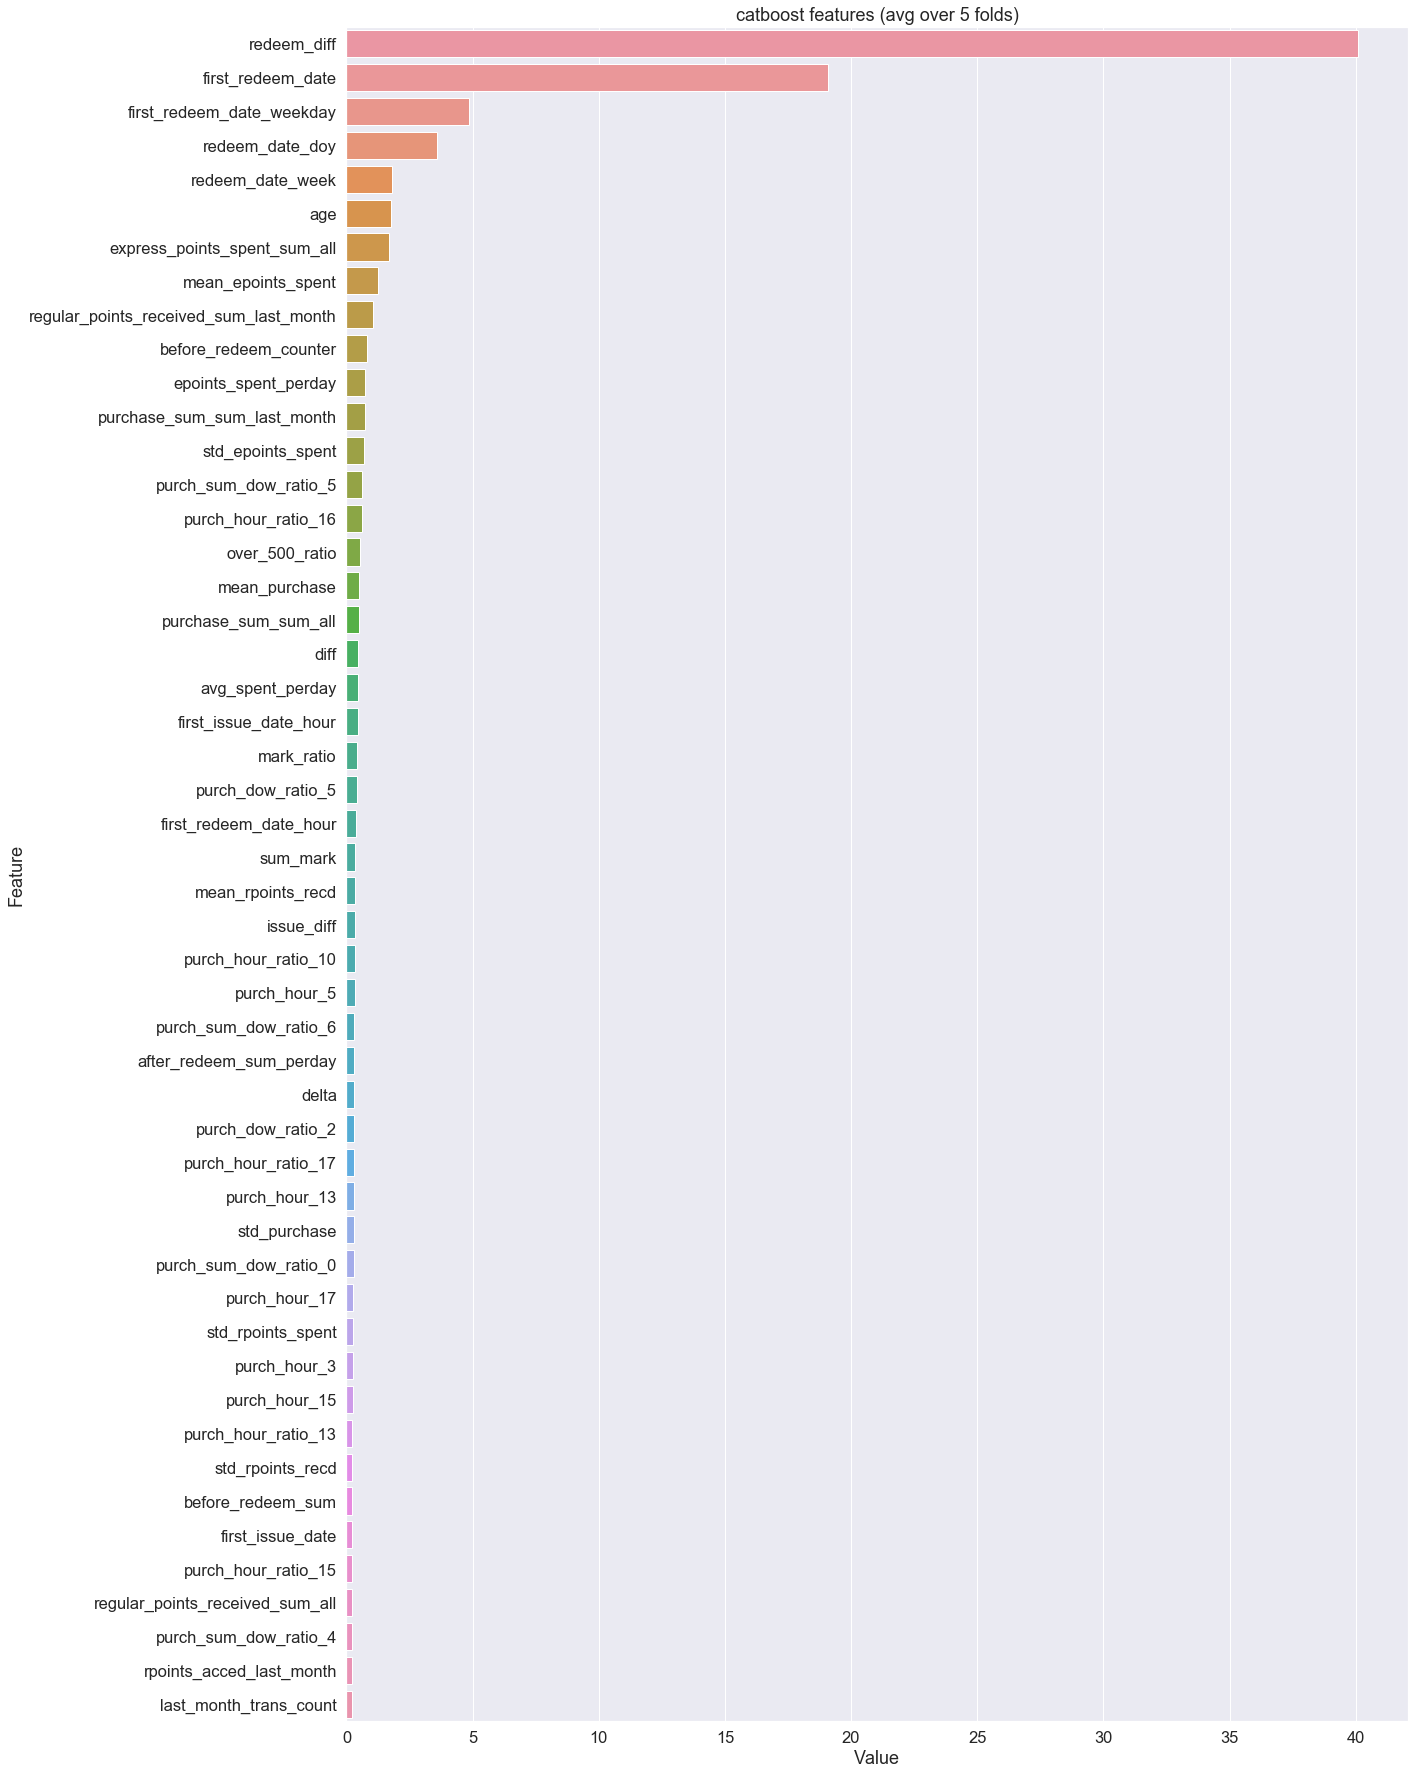

In [16]:
pred = trans_train_model('catboost', train_X, test_X, verbose=2, show_features=True)

In [17]:
df_submission = pd.DataFrame({'client_id':test_X.index.values,'uplift': pred})
df_submission.to_csv('sub_0.csv', index=False)